Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import cloudpickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym

from utils import save_data, load_data
import time

## Folder dir for saving and loading files

In [2]:
model_name = 'test_mtm'
model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q4
# q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [4]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

name = 'mtm'

if (name == 'mtm'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0,                  False, False, False),
                          (1,   0,  [2],    0,      0,              -0.21537,   q1,                 True,  False, True),
                          (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2,      True,  False, True),
                          (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2,  True,  True,  True)],
                         dh_convention='mdh',
                         friction_type=['Coulomb', 'viscous', 'offset'])

elif (name == 'psm'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,     0,          0,                     False, False, False),
                      (1,   0,  [2],   0,  sympy.pi/2,   0.5,   q1+sympy.pi/2,       True,  False, True),
                      (2,   1,  [3], 0.1, -sympy.pi/2,     0,   q2-sympy.pi/5,      True,  False, True),
                      (3,   2,  [4], 0.5,           0,     0,   -q2+sympy.pi/5+sympy.pi/2,    True,  False, True),
                      (4,   3,  [5],   1,           0,     0,    q2,                               True,  False, True),
                      (5,   4,  [6], 0.2, -sympy.pi/2,0.5+q3,    sympy.pi/2,        True,  False, True)],
                         dh_convention='mdh',
                         friction_type=['Coulomb', 'viscous', 'offset'])
    
elif( name == 'psm_long'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,     0,          0,                     False, False, False),
                      (1,   0,  [2],   0,  sympy.pi/2,   0.5,   q1+sympy.pi/2,       True,  False, True),
                      (2,   1,  [3], 0.1, -sympy.pi/2,     0,   q2-sympy.pi/5,      True,  False, True),
                      (3,   2,  [4], 0.5,           0,     0,   -q2+sympy.pi/5+sympy.pi/2,    True,  False, True),
                      (4,   3,  [5],   1,           0,     0,    q2,                               True,  False, True),
                      (5,   4,  [6], 0.2, -sympy.pi/2,0.5+q3,    sympy.pi/2,        True,  False, True),
                      (6,   5,  [7],   0,           0,   0.2,    -sympy.pi/2+q4,                True,  False, True),
                      (7,   6,[8,9], 0.5, -sympy.pi/2,     0,   -sympy.pi/2+q5,    False,  True, True),
                      (8,   7, [15], 0.3, -sympy.pi/2,     0,    -sympy.pi/2+q6-q7, False,  True, True),
                      (9,   7, [15], 0.3, -sympy.pi/2,     0,    -sympy.pi/2+q6+q7, False,  True, True),
                      (10,  2, [11],   0,           0,   0.5,    sympy.pi/5+sympy.pi/2,        False,  False, False),
                      (11, 10, [15],-0.5, +sympy.pi/2, 0.13*q3,    0, True,  False, True)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])


In [5]:
robot_def.Ia

In [6]:
robot_def.std_params

In [7]:
robot_def.bary_params

## Create kinematics chain

In [8]:
geom = Geometry(robot_def)


[[0]
 [0]
 [0]]
[[0]
 [0]
 [-0.215370000000000]]
[[0]
 [0]
 [-0.215370000000000]]
[[-0.279*sin(1)*cos(1)]
 [-0.279*sin(1)**2]
 [-0.21537 - 0.279*cos(1)]]


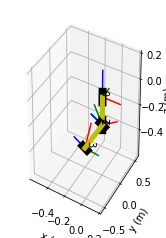

In [9]:
geom.draw_geom()

In [10]:
geom.T_0nc[2]

⎡                                                l2x⋅sin(q₂)⋅cos(q₁)   l2y⋅cos
⎢-sin(q₂)⋅cos(q₁)  -cos(q₁)⋅cos(q₂)  -sin(q₁)  - ─────────────────── - ───────
⎢                                                         m₂                  
⎢                                                                             
⎢                                                l2x⋅sin(q₁)⋅sin(q₂)   l2y⋅sin
⎢-sin(q₁)⋅sin(q₂)  -sin(q₁)⋅cos(q₂)  cos(q₁)   - ─────────────────── - ───────
⎢                                                         m₂                  
⎢                                                                             
⎢                                                          l2x⋅cos(q₂)   l2y⋅s
⎢    -cos(q₂)          sin(q₂)          0                - ─────────── + ─────
⎢                                                               m₂            
⎢                                                                             
⎣       0                 0             0           

## Create dynamics

In [11]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions and motor rotor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3))
Calculating M, C and G...
Calculating base parameter...
base parameter number: 25
Creating H_b function...
Finished creating robot dynamics
CPU times: user 1min 25s, sys: 193 ms, total: 1min 25s
Wall time: 1min 24s


In [12]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 25
Creating H_b function...


In [13]:
sympy.Matrix(dyn.base_param)

⎡             1.0⋅l3x              ⎤
⎢                                  ⎥
⎢             1.0⋅l3y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3xy             ⎥
⎢                                  ⎥
⎢             1.0⋅L3yz             ⎥
⎢                                  ⎥
⎢             1.0⋅l2y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3xz             ⎥
⎢                                  ⎥
⎢        1.0⋅l2x + 0.279⋅m₃        ⎥
⎢                                  ⎥
⎢             1.0⋅L2xy             ⎥
⎢                                  ⎥
⎢       1.0⋅L3xx - 1.0⋅L3yy        ⎥
⎢                                  ⎥
⎢       1.0⋅L2xz - 0.279⋅l3z       ⎥
⎢                                  ⎥
⎢             1.0⋅L3zz             ⎥
⎢                                  ⎥
⎢             1.0⋅L2yz             ⎥
⎢                                  ⎥
⎢-1.0⋅L2xx + 1.0⋅L2yy + 0.077841⋅m₃⎥
⎢                                  ⎥
⎢             1.0⋅Fv₁              ⎥
⎢

In [14]:
from data import RobotModel
import numpy
#Data to be saved
robot_model = RobotModel(dyn)
#robot_model.save_model(model_folder,model_name)

# model_name = 'test1'
# data_store = DataStore(model_folder, trajectory_folder, optimal_trajectory_folder, model_name, robot_model)
# data_store.save_data()

save_data(model_folder, model_name, robot_model)

#with open(model_file, 'wr') as f:
#    cloudpickle.dump(robot_model, f)

# x = robot_model.T_0n[3]
# y = robot_model.T_0n[2]

# print(x)
# print(y)

# print(x.shape)
# print(y.shape)

#x = numpy.matrix(robot_model.T_0n)
#print(robot_model.T_0n)
#print(x.shape)
#print(sympy.Matrix(x))

---
# 3 - Excitation trajectory optimization

Load Data

In [18]:
from data import RobotModel
from data import DataStore
import sympy
model_name = 'test_mtm'
model_folder = 'data/' + model_name + '/model/'

print(model_folder)

# data_store = DataStore(model_folder, trajectory_folder, optimal_trajectory_folder, model_name)
# robot_model = data_store.load_data()

robot_model = load_data(model_folder, model_name)

#model_file = model_folder + model_name + '.pkl'
#if os.path.exists(model_file):
#    robot_model = cloudpickle.load(open(model_file, 'rb'))
    

print(robot_model.p_n_func)

data/test_mtm/model/
[<function <lambda> at 0x7f761c0decf8>, <function <lambda> at 0x7f761c0dec08>, <function <lambda> at 0x7f761c0ded70>, <function <lambda> at 0x7f761c0dee60>]


## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [19]:
optimal_trajectory_folder = 'data/optimal_trajectory/'


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
trajectory_name = 'one'

base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)],cartesian_constraints = [(1,'max',1,0.4,1),(1,'min',-1,-1,-1) ])
                                                                                                                      
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 2
cartesian constraint number: 2
constraint number: 20
frames_constrained: [1.]
Condition number: 20.6220148825
x: [-0.08254753 -0.23470888 -0.03219262  0.5693098   0.61807797 -0.39163919
 -0.47782361  0.01899614  0.41456352  0.08477493  0.00460201 -0.71666102
  0.17533321  0.14440524  0.65547782  0.07630349  0.97117567 -0.23146093
 -0.99391587  0.65193362  0.35230689  0.88826092  0.26207768 -0.76413809
  0.93884206  0.74939696 -0.1688185   0.82627172 -0.48359132 -0.41759653
  0.44317346  0.6026206  -0.67895297  0.96444284 -0.70561853 -0.06724865
 -0.72430312 -0.02900458 -0.63068593]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    7.9886
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f          20.622    

## Plot optimal excitation trajectory

In [20]:
traj_optimizer.calc_frame_traj()
#print(traj_optimizer.frame_traj[0])

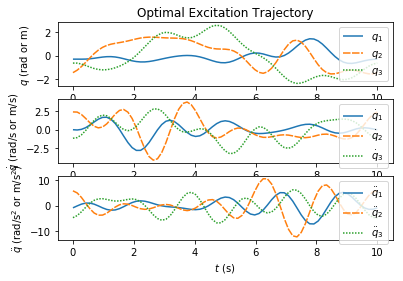

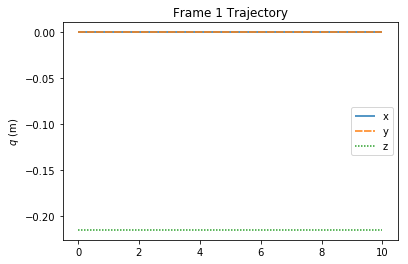

In [21]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj, traj_optimizer.const_frame_ind)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [22]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x)

#if not os.path.exists(dof_order_bf_x_dir):
# with open(dof_order_bf_x_dir, 'wr') as f:
#     cloudpickle.dump(dof_order_bf_x, f)

---
# Data processing

In [23]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [24]:
# Names as Arguments
model_name = 'test_mtm'
trajectory_name = 'one'

# Folders Standard
model_folder = 'data/' + model_name + '/model/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
results_folder = 'data/' + model_name +'/measured_trajectory/'
results_data_file = results_folder + trajectory_name + '.csv'

# Load Results
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(results_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

# Load Robot Model
robot_model = load_data(model_folder,model_name)

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [25]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


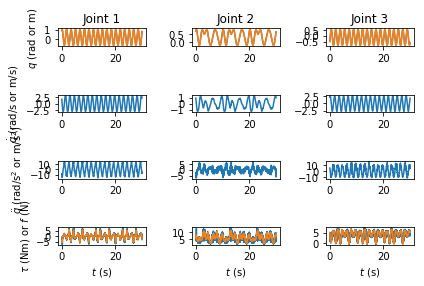

In [26]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [27]:
#traj_optimizer.x_result # not part of workflow

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [28]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [29]:
print(W_b.shape, tau_s.shape)

((17970, 25), (17970,))


In [30]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [31]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

⎡             1.0⋅l3x                  0.440700340176831  ⎤
⎢                                                         ⎥
⎢             1.0⋅l3y                 0.0853484882631924  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3xy                -0.019956080674416  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3yz                0.00177751777571017 ⎥
⎢                                                         ⎥
⎢             1.0⋅l2y                 -0.0154761436351049 ⎥
⎢                                                         ⎥
⎢             1.0⋅L3xz               -0.000261415414370027⎥
⎢                                                         ⎥
⎢        1.0⋅l2x + 0.279⋅m₃            0.834550933086848  ⎥
⎢                                                         ⎥
⎢             1.0⋅L2xy               0.000387150655003027 ⎥
⎢                                                         ⎥
⎢       1.0⋅L3xx - 1.0⋅L3yy           -0

## Compare measured torque and predicted torque

### Generate predicted torque

In [32]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]
    

### Evaluate regression

In [33]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022622311192344877
standard deviation of xb using OLS:
[3.67191305e-04 2.75635478e-04 7.66934020e-05 1.84915678e-04
 1.88995652e-03 9.35639086e-05 8.13867056e-04 1.82613200e-04
 1.80714236e-04 1.97510244e-04 1.39036811e-04 2.59991381e-04
 4.68303114e-04 7.35977160e-04 1.68869485e-03 1.15824303e-03
 1.65652930e-04 1.13811065e-04 4.86625300e-04 1.83817954e-02
 6.14692331e-04 3.19810392e-03 1.40211505e-03 1.35852300e-03
 1.55279813e-03]
percentage of standard deviation of xb using OLS: 
[8.33199504e-04 3.22952971e-03 3.84310944e-03 1.04030284e-01
 1.22120637e-01 3.57912745e-01 9.75215560e-04 4.71685113e-01
 1.72551885e-03 4.11679070e-01 1.04417594e-03 2.50815397e-01
 1.76094669e-03 2.25973323e-01 1.10583881e-01 5.98229453e-02
 1.37504654e-02 7.36540471e-04 2.71764499e-03 4.80785930e-02
 9.68941329e-02 2.81143785e-02 6.80939392e-02 3.01286191e+00
 1.63342137e-01]


### Plot measured torque and predicted torque

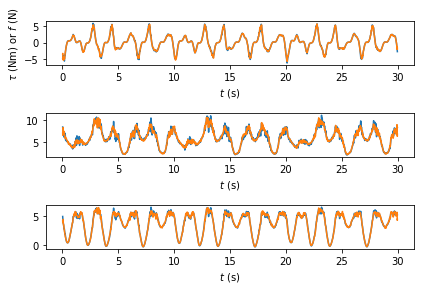

In [34]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [35]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [36]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [37]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [38]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [39]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.05, 0.05),
                  (0.5, 10, 0, 0.3, 0, 0.1, -0.05, 0.05)]

sdp_constraints = [(0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 2, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01)]

In [40]:
sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 40)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Ia3 param40
Solving problem...
[ 5.05454123e-06  0.00000000e+00  0.00000000e+00  5.05454123e-06
  0.00000000e+00  1.02027256e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.02186516e+00  1.15895153e-03  6.21843090e-03
  6.26571254e-03  1.67757862e-02  1.27923043e-03  1.00176550e-03
  1.49382983e-01  5.05271569e-04  1.25566069e-01  3.99822814e-01
  1.34128264e-03 -7.32957458e-03  2.99833900e+00  6.44713185e-03
  5.86822382e-03  9.35162445e-03  3.26097591e-02 -2.06679605e-02
 -1.12189288e-03  1.36212674e-01  1.26942012e-03  1.24636922e-01
  4.52904789e-01  7.95054568e-02  2.86758023e-03  1.69235798e+00
  1.27772610e-02  2.59175565e-03 -2.03874530e-03  7.51071930e-04]


In [41]:
len(sdp_opt_std._constraints)

## Compare measured torque and predicted torque

### Generate predicted torque

In [42]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

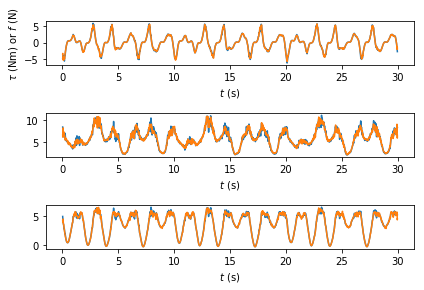

In [43]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [44]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx  5.05454123293039e-6 ⎤
⎢                          ⎥
⎢L1xy          0.0         ⎥
⎢                          ⎥
⎢L1xz          0.0         ⎥
⎢                          ⎥
⎢L1yy  5.05454123293039e-6 ⎥
⎢                          ⎥
⎢L1yz          0.0         ⎥
⎢                          ⎥
⎢L1zz  1.02027256158601e-5 ⎥
⎢                          ⎥
⎢l1x           0.0         ⎥
⎢                          ⎥
⎢l1y           0.0         ⎥
⎢                          ⎥
⎢l1z           0.0         ⎥
⎢                          ⎥
⎢ m₁     1.02186515608653  ⎥
⎢                          ⎥
⎢Fc₁   0.00115895152669689 ⎥
⎢                          ⎥
⎢Fv₁   0.00621843089597379 ⎥
⎢                          ⎥
⎢Fo₁   0.00626571253626371 ⎥
⎢                          ⎥
⎢L2xx   0.0167757861885383 ⎥
⎢                          ⎥
⎢L2xy   0.0012792304311218 ⎥
⎢                          ⎥
⎢L2xz  0.00100176549783867 ⎥
⎢                          ⎥
⎢L2yy   0.149382982571649  ⎥
⎢                          ⎥
⎢L2yz  0.00050

In [45]:
from identification import barycentric2standard_params

In [46]:
sdp_opt_std.x_result

array([ 5.05454123e-06,  0.00000000e+00,  0.00000000e+00,  5.05454123e-06,
        0.00000000e+00,  1.02027256e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.02186516e+00,  1.15895153e-03,  6.21843090e-03,
        6.26571254e-03,  1.67757862e-02,  1.27923043e-03,  1.00176550e-03,
        1.49382983e-01,  5.05271569e-04,  1.25566069e-01,  3.99822814e-01,
        1.34128264e-03, -7.32957458e-03,  2.99833900e+00,  6.44713185e-03,
        5.86822382e-03,  9.35162445e-03,  3.26097591e-02, -2.06679605e-02,
       -1.12189288e-03,  1.36212674e-01,  1.26942012e-03,  1.24636922e-01,
        4.52904789e-01,  7.95054568e-02,  2.86758023e-03,  1.69235798e+00,
        1.27772610e-02,  2.59175565e-03, -2.03874530e-03,  7.51071930e-04])

In [48]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [50]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx   5.05454123293039e-6 ⎤
⎢                           ⎥
⎢I1xy            0          ⎥
⎢                           ⎥
⎢I1xz            0          ⎥
⎢                           ⎥
⎢I1yy   5.05454123293039e-6 ⎥
⎢                           ⎥
⎢I1yz            0          ⎥
⎢                           ⎥
⎢I1zz   1.02027256158601e-5 ⎥
⎢                           ⎥
⎢r1x            0.0         ⎥
⎢                           ⎥
⎢r1y            0.0         ⎥
⎢                           ⎥
⎢r1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     1.02186515608653   ⎥
⎢                           ⎥
⎢Fc₁    0.00115895152669689 ⎥
⎢                           ⎥
⎢Fv₁    0.00621843089597379 ⎥
⎢                           ⎥
⎢Fo₁    0.00626571253626371 ⎥
⎢                           ⎥
⎢I2xx   0.0167572687017968  ⎥
⎢                           ⎥
⎢I2xy   0.0014580879251093  ⎥
⎢                           ⎥
⎢I2xz   2.43806391970725e-5 ⎥
⎢                           ⎥
⎢I2yy   0.0960494516531994  ⎥
⎢         